In [100]:
%matplotlib inline

In [1]:
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy import stats
sns.set_palette("husl")

In [3]:
#Url of the phageParser API
apiurl = 'https://phageparser.herokuapp.com'
#Get the initial page for listing of accessible objects and get url for organisms and casproteins
url_json=requests.get(apiurl).json()
organisms_url = url_json['organisms']
cas_proteins_url = url_json['casproteins']

In [4]:
#Iterate through each page and merge the json response into a dictionary for cas proteins
cas_protein_dict = {}
r=requests.get(cas_proteins_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = cas_proteins_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    cas_protein_objs = payload['cas_proteins']
    for cas_protein_obj in cas_protein_objs:
        cas_protein_dict[cas_protein_obj['id']] = cas_protein_obj

In [5]:
#Iterate through each page and merge the json response into a dictionary for organisms
organism_dict = {}
r=requests.get(organisms_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = organisms_url+'?page={}&include[]=cas_proteins&include[]=loci.spacers'.format(page)
    payload = requests.get(url).json()
    organism_objs = payload['organisms']
    for organism_obj in organism_objs:
        organism_dict[organism_obj['id']] = organism_obj

In [6]:
#Make a set of specific cas proteins by grouping them from gene field
cas3_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas3' in v['gene']}
cas9_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas9' in v['gene']}
cas10_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas10' in v['gene']}

In [7]:
#Estimate the CRISPR type in organisms by checking the identified cas proteins in each organism
#Also find the locus size by checking if all of the loci in an organism consist of a single spacer
for k,v in organism_dict.items():
    v['CRISPR_type'] = []
    v['single_spacer'] = False
    if v['cas_proteins']:
        org_proteins = set(v['cas_proteins'])
        if not org_proteins.isdisjoint(cas3_proteins): #has cas3 proteins
            v['CRISPR_type'] += ['Type I']
        if not org_proteins.isdisjoint(cas9_proteins): #has cas9 proteins
            v['CRISPR_type'] += ['Type II']
        if not org_proteins.isdisjoint(cas10_proteins): #has cas10 proteins
            v['CRISPR_type'] += ['Type III']
    if v['loci']:
        if all([len(loc['spacers']) < 2 for loc in v['loci']]):
            v['single_spacer'] = True

In [8]:
#Calculate the availability of an active CRISPR system for each organism, group by single or multiple spacers.
iscrispr_single_spacer = [bool(v['CRISPR_type']) for k,v in organism_dict.items() if v['single_spacer']]
iscrispr_multi_spacer = [bool(v['CRISPR_type']) for k,v in organism_dict.items() if not v['single_spacer']]
iscrispr_single_spacer_prc = sum(iscrispr_single_spacer)/len(iscrispr_single_spacer)*100
iscrispr_multi_spacer_prc = sum(iscrispr_multi_spacer)/len(iscrispr_multi_spacer)*100
print("Active CRISPR system percentage for organisms with single spacer is {:.2f}%".format(iscrispr_single_spacer_prc))
print("Active CRISPR system percentage for organisms with multiple spacer is {:.2f}%".format(iscrispr_multi_spacer_prc))

Active CRISPR system percentage for organisms with single spacer is 97.46%
Active CRISPR system percentage for organisms with multiple spacer is 97.32%


Things to include:
- [x] cas proteins
- [x] locus length
- [x] self-targeting spacers
- [ ] prophages
- [ ] active vs inactive from vasu?

In [20]:
self_spacers_url = url_json['organismselfspacers']

In [21]:
#Iterate through each page and merge the json response into a dictionary for self-targeting spacers
self_spacers_dict = {}
r=requests.get(self_spacers_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = self_spacers_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    self_spacer_objs = payload['organism_self_spacers']
    for self_spacer_obj in self_spacer_objs:
        self_spacers_dict[self_spacer_obj['id']] = self_spacer_obj

In [165]:
self_spacers_dict[35]

{'evalue': 6.04178e-14,
 'genomic_end': 1364399,
 'genomic_start': 1364435,
 'id': 35,
 'organism': 84,
 'spacer': 2442}

In [174]:
# check for which organisms have self-targeting spacers

for key, value in self_spacers_dict.items():
    if value['evalue'] < 10**-5:
        org_id = value['organism']        
        try: # if there's already a self-spacer key, add to it
            organism_dict[org_id]['self_spacer'][key] = value
        except:
            organism_dict[org_id]['self_spacer'] = {key:value}
        

In [92]:
# load data on which organisms have active accessions

active_accessions = pd.read_table("../data/active_accessions.txt",header = None)
active_accessions = np.array(active_accessions).flatten()

In [240]:
# count self-targeting spacers

num_self_targeting = np.zeros((len(organism_dict), 2))

i = 0
for key, value in organism_dict.items():
    try:
        spacer_ids = []
        for k, v in value['self_spacer'].items():
            spacer_ids.append(v['spacer']) 
        num_unique = len(np.unique(spacer_ids)) # count only number of unique spacers that are self-targeting
        num_self_targeting[i,0] += num_unique
            
        for l in value['loci']:
            num_self_targeting[i,1]+=(len(l['spacers']))
            
    except:
        for l in value['loci']:
            num_self_targeting[i,1]+=(len(l['spacers']))
            
    if num_self_targeting[i,1] == num_self_targeting[i,0] and num_self_targeting[i,1] >0: # if all spacers are self-targeting
        num_self_targeting[i] = np.array([0,0])
        
    i += 1
    

The problem is that some of the CRISPRdb locus positions are wrong: see https://github.com/phageParser/phageParser/issues/264

Note that this is number of spacers per organism, not locus, so this distribution looks a bit different from the other one. The max spacers per organism is pretty high here. 

(0.8, 1000)

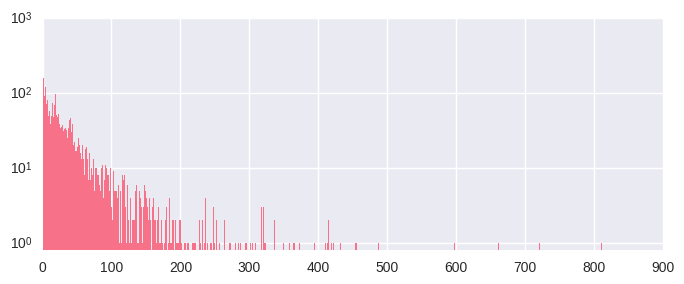

In [223]:
plt.figure(figsize = (8,3))
bins = plt.hist(num_self_targeting[:,1],bins = np.arange(0,900,1),edgecolor="none")
plt.yscale('log')
plt.ylim(0.8, 10**3)

In [185]:

spacer_ids = []
for key, value in organism_dict[2639]['self_spacer'].items():
    spacer_ids.append(value['spacer'])
    #print(value)


In [187]:
np.unique(spacer_ids)

array([ 21160,  44750,  84249,  84250, 103724, 123851])

In [184]:
organism_dict[2639]['self_spacer'].items()

dict

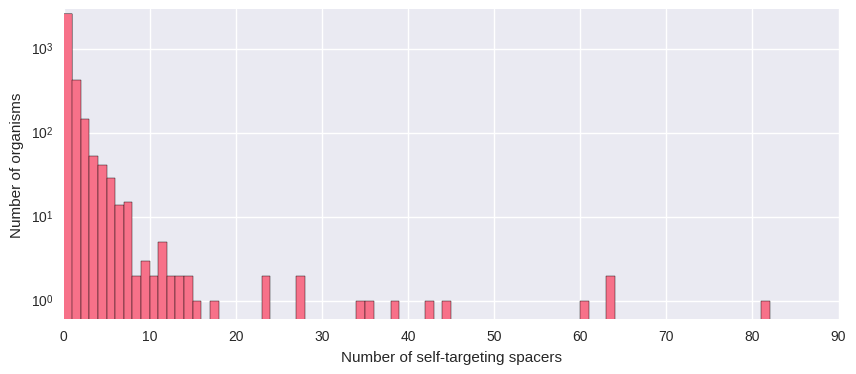

In [241]:
# plot: number of self-targeting spacers per organism

plt.figure(figsize = (10,4))
plt.hist(num_self_targeting[:,0], bins = np.arange(0,90,1))
plt.yscale('log')
plt.ylim(6*10**-1, 3*10**3)
plt.ylabel("Number of organisms")
plt.xlabel("Number of self-targeting spacers")

(0.5, 100)

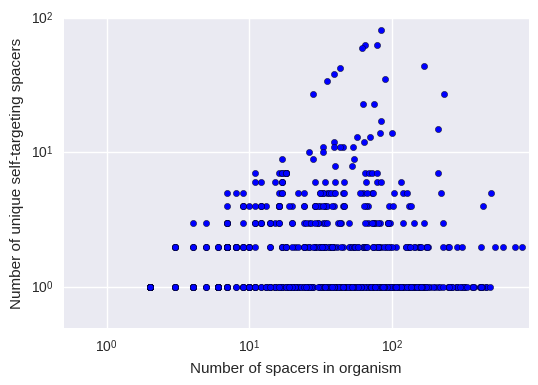

In [242]:
# plot number of self-targeting spacers vs. number of spacers

plt.figure()
plt.scatter(num_self_targeting[:,1], num_self_targeting[:,0])
plt.ylabel("Number of unique self-targeting spacers")
plt.xlabel("Number of spacers in organism")
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.5, 900)
plt.ylim(0.5, 100)

That straight line at $y=x$ is weird, right? Check these organisms.